# Example of Tool Functionalities using some Real Cell Data

## 1. Import

In [1]:
import sys
sys.path.append('../') # Necessary to access classes functions from other folder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv as cv
import classes.data_prep as prep
import classes.gp as gp
import classes.data_visualisation as visualisation
import classes.optimisation as optimisation
import classes.model_selection as model_selection
from matplotlib.backends.backend_pdf import PdfPages

import warnings # Necessary to avoid certain common warnings from coming up. Won't affect inference.
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

## 2. Import Data from Excel and Prep it

Collecting real data from an **excel spreadsheet** is made easy thanks to the *gel_excel()* function in the data_prep class.

To prep the collected data we need to:
 - **convert time** to hours,
 - **normalise** the data, and
 - **detrend** it.
 
The detrending step is explained in detail in the docs, under *detrending.md*. In short, we fit a SE Gaussian Process to find the smooth long term trend of the time series. The choice of the **detrending set of parameters** is made within the function through an optimisation procedure by maximising the negative marginal likelihood.


- - - 
*Note:* local file path is "Gene-Expression-Data-Analysis-with-Gaussian-Process/data"

In [10]:
df = prep.Data_Input().get_excel()
df_control = prep.Data_Input().get_excel()

number_of_observed_cells = 20
number_of_control_cells = 20

# Check no NaNs are present/remove if so, then store in list.

observed_cells = prep.Data_Input().remove_nans(number_of_observed_cells, df)
control_cells = prep.Data_Input().remove_nans(number_of_control_cells, df_control)

# Time in Hours

time = df.iloc[:,0]
time = time.to_numpy()[2:len(time)]     #Store Time into a numpy array. #todo: change 2 to 1 when formatting convention has been finalised.
time = time/(60*60*1000)

control_time = df_control.iloc[:,0]
control_time = control_time.to_numpy()[2:len(control_time)]     #Store Time into a numpy array. #todo: change 2 to 1 when formatting convention has been finalised.
control_time = control_time/(60*60*1000)

# Normalisation

normalised_cells = prep.Normalisation().normalise_many_cells_from_list(observed_cells)
normalised_control_cells = prep.Normalisation().normalise_many_cells_from_list(control_cells)

# Detrending

detrending_parameter = 0.0001
detrended_data = prep.Detrending(alpha = detrending_parameter).detrend_data_from_list(time, normalised_cells)
detrended_control_data = prep.Detrending(alpha = detrending_parameter).detrend_data_from_list(control_time, normalised_control_cells)[0]


 Excel File Path : /Users/erikangravina/Documents/GitHub/Gene-Expression-Data-Analysis-with-Gaussian-Process/data/Hes1 Promoter 2013.xlsx
 Excel File Path : /Users/erikangravina/Documents/GitHub/Gene-Expression-Data-Analysis-with-Gaussian-Process/data/Control Promoter.xlsx
Length of observations 53 for cell 1
Length of observations 53 for cell 2
Length of observations 53 for cell 3
Length of observations 53 for cell 4
Length of observations 53 for cell 5
Length of observations 53 for cell 6
Length of observations 53 for cell 7
Length of observations 53 for cell 8
Length of observations 53 for cell 9
Length of observations 53 for cell 10
Length of observations 53 for cell 11
Length of observations 53 for cell 12
Length of observations 53 for cell 13
Length of observations 53 for cell 14
Length of observations 53 for cell 15
Length of observations 53 for cell 16
Length of observations 53 for cell 17
Length of observations 53 for cell 18
Length of observations 53 for cell 19
Length of obs

#### Plot of one Detrended Traces against the Original Normalised Signal

(-3, 4)

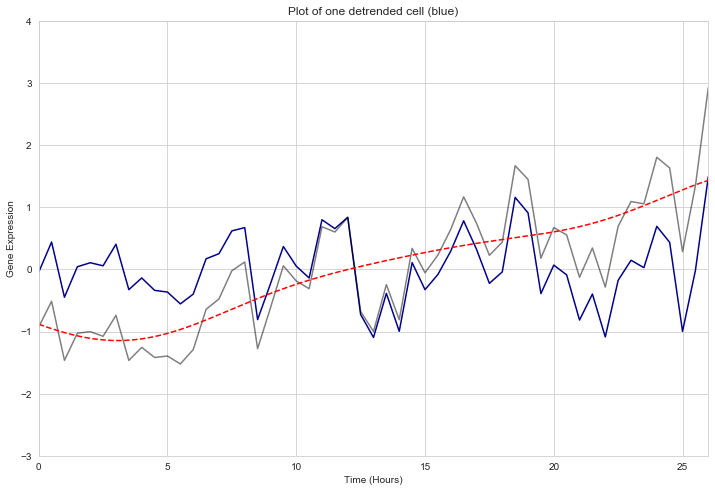

In [11]:
detrended_cells, trendfit_x, trendfit_y = detrended_data

#trendfit_x = detrended_data[1]
#trendfit_y_cell = detrended_data[2][0]
#detrended_cell = detrended_data[0][0]
#detrended_data = detrended_data[0]

Fig = plt.figure("Detrended Data", figsize = (12, 8))
plt.title("Plot of one detrended cell (blue)")
plt.xlabel("Time (Hours)")
plt.ylabel("Gene Expression")
plt.plot(time[0:len(detrended_cells[0])], detrended_cells[0], color = 'darkblue')
plt.plot(time[0:len(detrended_cells[0])], normalised_cells[0], color = 'black', alpha = 0.5)
plt.plot(trendfit_x, trendfit_y[0], ls = '--', color = 'red')
plt.xlim(0, time[0:len(detrended_cells[0])][-1])
plt.ylim(-3, 4)

# - - 
# Merge
# observed_timepoints = observed_cells[:,0]
# cells = np.hstack((observed_cells[:,1:11], control_cells[:,1:11]))

## 3. Initial Plot of GP Fit of one observed cell and one control cell for some arbitrary parameters.

For a quick visualisation of an initial fit, the class Visualisation_GP() works well.

##### Inputs required include:
 - parameters of choice $ \alpha, $ $ \beta, $ $ \sigma, $ $ \sigma_{n} $
 - the observed datapoints,
 - the time duration (in hours),
 - the number of fitted observations to produce,
 - the number of random traces to plot.


***Notes:***


 - on the *left hand side plot* you will see a plot of two prior traces (orange and blue), meaning it is a sample from the OU (or OUosc) Gaussian Process, **prior to observing any data**. This means the prior trace is not dependent on anything but the definition of the covariance function and the parameters used to fit it.
 
 
 - on the *right hand size plot* you will see a plot of two posterior traces (orange and blue), these are random traces taken from the OU (or OUosc) Gaussian Process, **after having observed data**. This means the prior trace has been trained using the observed data points. Moreover, the black line is the posterior mean predictor, equivalent to the fit of the Gaussian Process to the data.

- - - Select some arbitrary parameters for the GP fit to observe an initial Prior and Posterior Fit - - -
 -            -            -          -            -  
Input alpha : 0.1
Input beta : 0.5
Input variance : 1.0
Input noise : 0.1


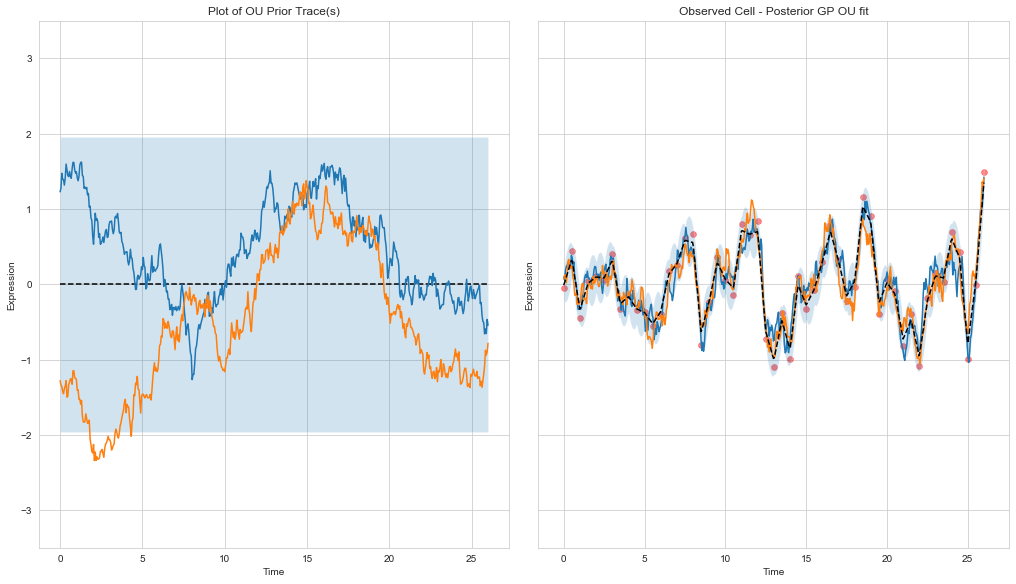

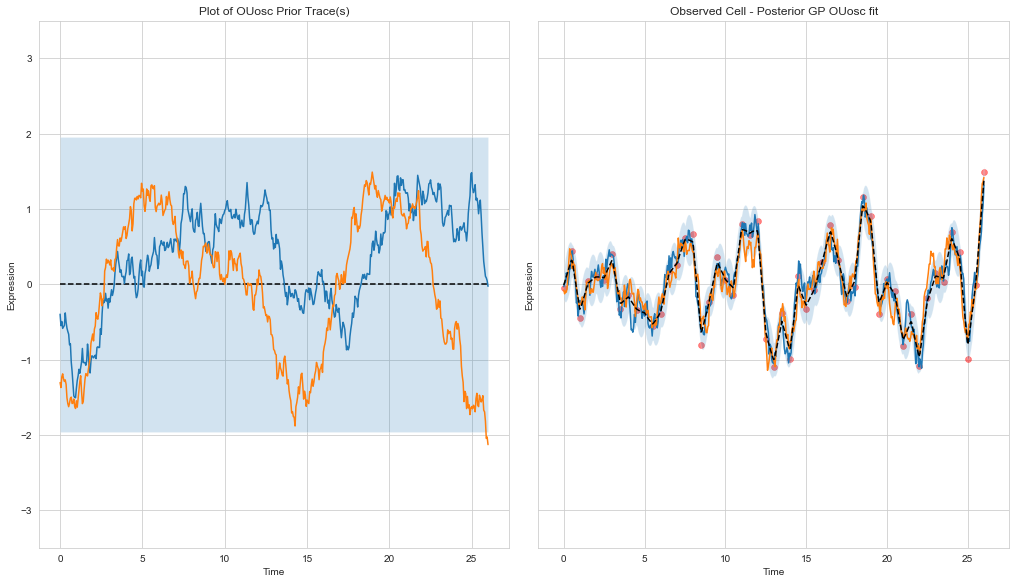

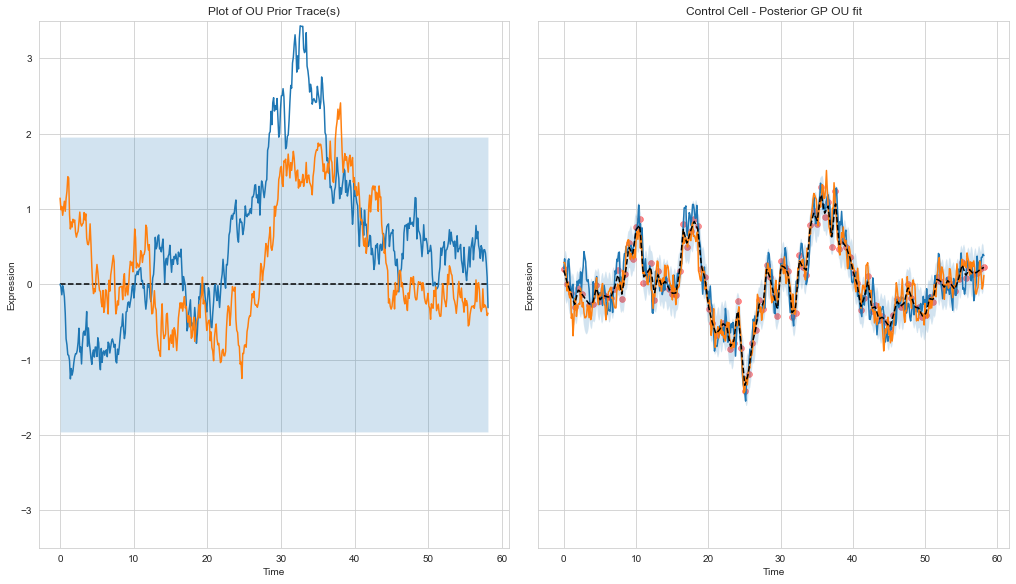

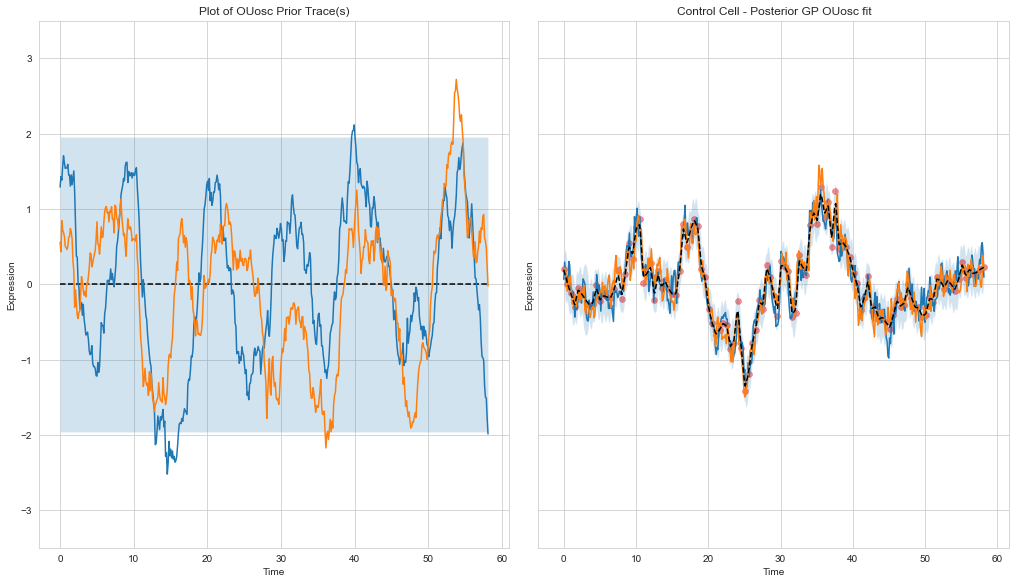

In [14]:
print("- - - Select some arbitrary parameters for the GP fit to observe an initial Prior and Posterior Fit - - -")
print(" -            -            -          -            -  ")

alpha = float(input("Input alpha : "))
beta = float(input("Input beta : "))
variance = float(input("Input variance : "))
noise = float(input("Input noise : "))

# - - - - Observed Cell

detrended_cell = detrended_cells[0]
time_cell = time[0:len(detrended_cells[0])]

GP_OU_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = False, observed_timepoints = time_cell, observed_y = detrended_cell, cholesky_decompose = True)
GP_OUosc_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = True, observed_timepoints = time_cell, observed_y = detrended_cell, cholesky_decompose = True)

# OU Model - Non Oscillatory Fit
GP_OU_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = time_cell[-1], number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Observed Cell - Posterior GP OU fit")
plt.show()
# OUosc Model - Oscillatory Fit
GP_OUosc_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = time_cell[-1], number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Observed Cell - Posterior GP OUosc fit")
plt.savefig("Observed-Cell-GP-OUosc-Fit.pdf")
plt.show()

# - - - - Control Cell

detrended_control_cell = detrended_control_data[0]
time_control_cell = control_time[0:len(detrended_control_cell)]

control_GP_OU_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = False, observed_timepoints = time_control_cell, observed_y = detrended_control_cell, cholesky_decompose = True)
control_GP_OUosc_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = alpha, beta = beta, variance = variance, noise = noise, oscillatory = True, observed_timepoints = time_control_cell, observed_y = detrended_control_cell, cholesky_decompose = True)

# OU Model - Non Oscillatory Fit
control_GP_OU_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = time_control_cell[-1], number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Control Cell - Posterior GP OU fit")
plt.show()
# OUosc Model - Oscillatory Fit
control_GP_OUosc_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = time_control_cell[-1], number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Control Cell - Posterior GP OUosc fit")
plt.show()

## 3. Hyper Parameter Estimation for one cell

Even though a quick visualisation as above can be useful, in practice we would not know what hyper parameters are the true ones. This section aims to estimate $ \alpha, $ $ \beta, $ $ \sigma, $ $ \sigma_{n} $ by maximising the negative marginal likelihood.

For a quick optimisation of a single cell input, the class Optimisation() serves well. This section will demonstrate the optimisation and subsequent fitting using the optimised parameters for a single cell. 

*Note:* If you wish to carry the estimation on more than one cell a simple loop will suffice. This has been done successfully in the code for the model selection bootstrap which optimises over 2000 cells! So you can take a look in model_selection.py for inspiration if needed.

##### Inputs required for Optimisation() Class include:

 - Observed timepoints;
 - Observed expression level;
 - Specify whether you are optimising an **oscillatory or non-oscillatory** signal.
     - *Note:* this will change the model optimised (OU or OUosc) since the covariance function is involved in the evaluation of the Log Marginal Likelihood.

##### Inputs required for the optimizing_neg_marginal_loglikelihood() function include:

 - **Start values** that you wish your optimisation to start from.
     - *Note:* Be careful of local minima.
 - As *optionals* you may change the **optimisation method**. I recommend checking out the documentation before making any changes to the methods and **bounds** used.
     - *Note:* that hyper-priors (or simply priors on the hyperparameters) are set here by choosing certain bounds.

- - - Select starting parameter values to carry out an optimisation of the Log Marginal Likelihood - - -
 -            -            -          -            -  
Input starting value alpha : 0.5
Input starting value beta : 0.5
Input starting value variance : 0.5
Input starting value noise : 0.5
Callback for the Optimisation Function:
Iter    Alpha       Beta        Variance    Noise        Log Marginal Likelihood
   1    0.430610    0.542612    0.430610    0.430610     46.984612
   2    0.396345    0.582745    0.360010    0.396323     46.334886
   3    0.390247    0.629470    0.273716    0.389570     45.849603
   4    0.397934    0.696945    0.173124    0.399159     45.177937
   5    0.417746    0.802338    0.098684    0.432640     44.240893
   6    0.496605    0.974370    0.153915    0.502403     44.127762
   7    0.472179    0.985993    0.087663    0.493913     43.634204
   8    0.463076    0.967821    0.095748    0.480958     43.594130
   9    0.455093    0.982776    0.099203    0.472

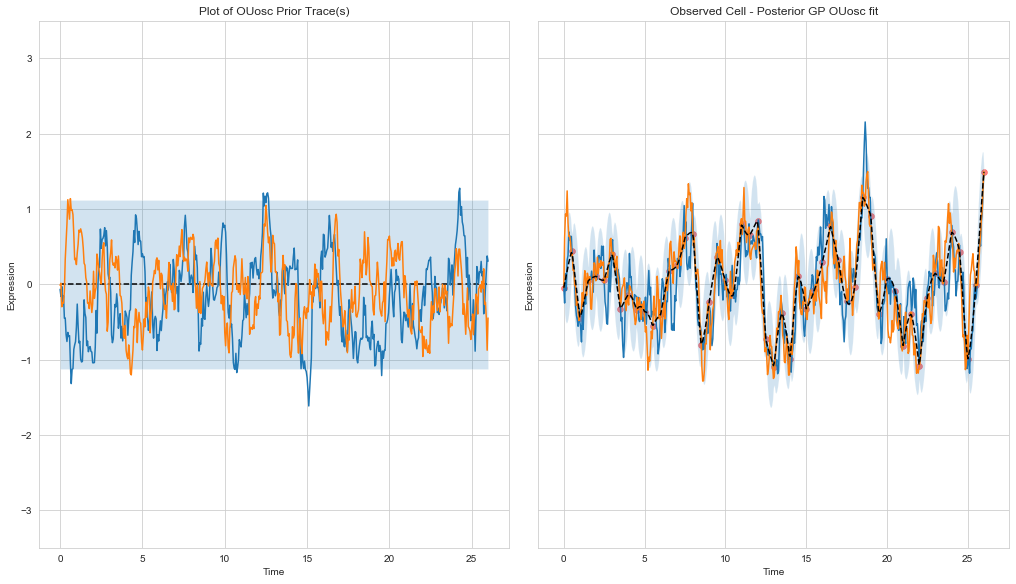

In [15]:
print("- - - Select starting parameter values to carry out an optimisation of the Log Marginal Likelihood - - -")
print(" -            -            -          -            -  ")

start_alpha = float(input("Input starting value alpha : "))
start_beta = float(input("Input starting value beta : "))
start_variance = float(input("Input starting value variance : "))
start_noise = float(input("Input starting value noise : "))

# Observed Cell

observed_optim = optimisation.Optimisation(oscillatory = True, observed_timepoints = time_cell, observed_y = detrended_cell)
observed_optim = observed_optim.optimizing_neg_marginal_loglikelihood_callback(start_values = [start_alpha, start_beta, start_variance, start_noise], method = 'L-BFGS-B', bounds = ((1e-10, None), (None, None), (1e-10, None), (1e-10, None)), cholesky_decompose = True, callback = True)

# Control Cell

control_optim = optimisation.Optimisation(oscillatory = False, observed_timepoints = time_control_cell, observed_y = detrended_control_cell)
control_optim = control_optim.optimizing_neg_marginal_loglikelihood(start_values = [start_alpha, start_beta, start_variance, start_noise], method = 'L-BFGS-B', bounds = ((1e-10, None), (None, None), (1e-10, None), (1e-10, None)), cholesky_decompose = True)

print("- - - Example Callback for the Observed Cell - - -")
optim = observed_optim[0]
optim_results = observed_optim[0].x
print("- - - Comparing estimated parameters versus input ones for Oscillatory Model - - -")
print("- - - Results for Observed Cell - - -")
print("Estimated Alpha:", optim_results[0])
print("Estimated Beta:", optim_results[1])
print("Estimated Variance:", optim_results[2])
print("Estimated Noise:", optim_results[3])

# - - - - Plot of Observed Cell Fit using Optimisation Values

GP_OUosc_fit_arbitrary_parameters = visualisation.Visualisation_GP(alpha = optim_results[0], beta = optim_results[1], variance = optim_results[2], noise = optim_results[3], oscillatory = True, observed_timepoints = time_cell, observed_y = detrended_cell, cholesky_decompose = True)

# OUosc Model - Oscillatory Fit
GP_OUosc_fit_arbitrary_parameters.gp_ou_trace_subplot(duration = time_cell[-1], number_of_observations = 500, number_of_traces = 2)[0]
plt.title("Observed Cell - Posterior GP OUosc fit")
plt.show()

## 4. Optimisation Plots

These are optional and will be expanded. 


The **first plot**, using *plotting_hyperparameters_densities_2d()* uses the results from the optimiser.
In turn, it fixes all other parameters using their optimum values and lets one vary with respect to the Log Marginal Likelihood. More on this in the docs.


The **second plot** using *plotting_hyperparameters_densities_3d()* does the same but for a range of values of your choice. This time the process is done with respect to two hyperparameters, to yield a 3D plot of how certain hyperparameters vary together.

##### Inputs required for the Visualisation_Optimiser() Class are:

 - Observed timepoints;
 - Observed expression level;
 - Specify whether you are optimising an **oscillatory or non-oscillatory** signal;
 - Optimizer result, as in the output of the optimisation function.
 
##### Inputs required for the 3D plot are:

 - the x and y axis range for the parameters (usually from 0 to 3)
 - the hyperparameter combination to plot on the x and y axis respectively e.g. ['alpha', 'beta']
 

*Note*: in other platforms (not jupyter notebook) the 3D plots are interactive and can be moved around much more easily.

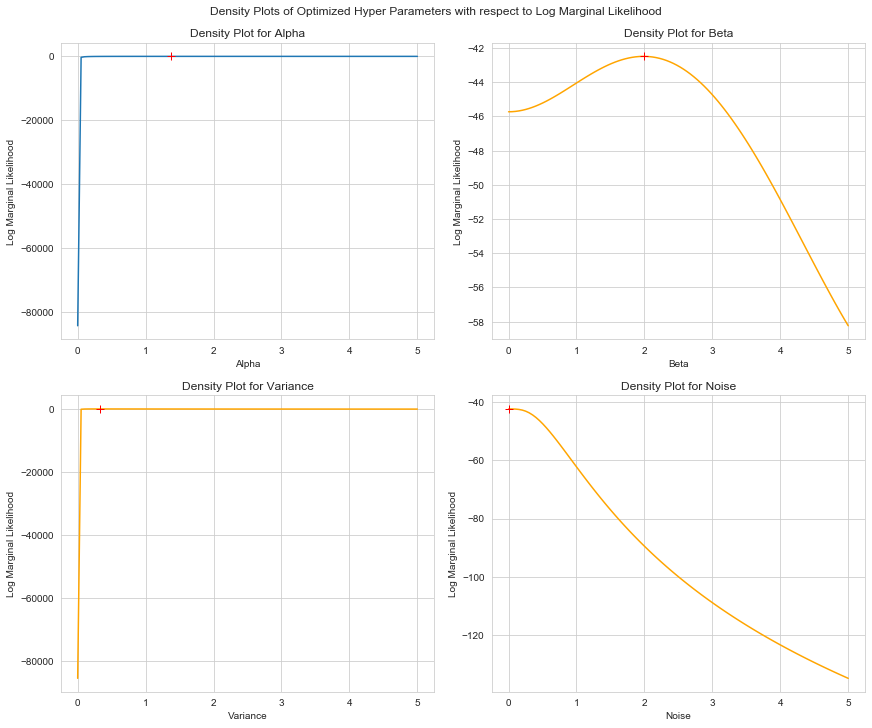

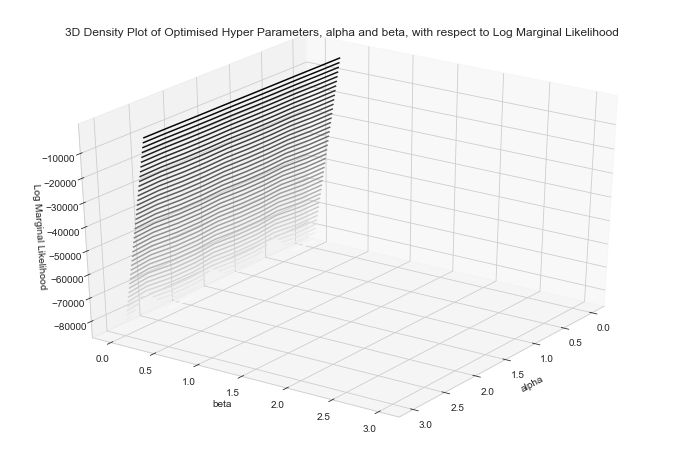

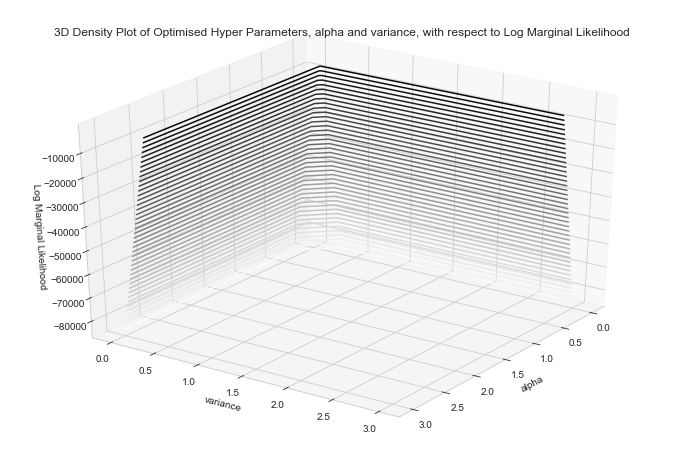

In [16]:
# The first plot,
optimisation_plot = visualisation.Visualisation_Optimiser(oscillatory = True, observed_timepoints = time_cell, observed_y = detrended_cell, optimizer_result = optim)

optimisation_plot.plotting_hyperparameters_densities_2d()
plt.show()

# The second plot, 
optimisation_plot.plotting_hyperparameters_densities_3d(range = [0,3], hyperparameters = ['alpha', 'beta'])
plt.title("3D Density Plot of Optimised Hyper Parameters, alpha and beta, with respect to Log Marginal Likelihood")
plt.show()
optimisation_plot.plotting_hyperparameters_densities_3d(range = [0,3], hyperparameters = ['alpha', 'variance'])
plt.title("3D Density Plot of Optimised Hyper Parameters, alpha and variance, with respect to Log Marginal Likelihood")
plt.show()

# These are particularly uninteresting for this example but it is not always necessarily the case.

## 5. Model Selection Process for all observed and control cells

This model selection relies on the **bootstrap approximation of the distribution of LLRs for a population of non-oscillating cells**. This is then used as a frame of reference to compare our observed LLR distributions to identify both visually and analytically whether our sample of observed cells are behaving in an oscillatory or non-oscillatory manner. Analytically the estimation of q-values is used.

For more information on the Model Selection process in detail I recommend checking out the docs.

- - - 

**Warning**: Model selection is currently the most expensive in terms of running time.

For the current number of observations (20 control and 20 observed cells):
- Selecting 200 Synthetic Cells take ~15 minutes (per group) to produce a result
- Selecting 2000 synthetic cells take about ~2 hours (per group) to produce a result.

These are a general guideline however, since other factors play a part into the computation time. For example, a higher number of observations of each cell increases the computation time.

Whilst a larger population of Synthetic Cells is the appropriate bootstrap, for this example we will keep to 200 Synthetic Cells.

Completed Fitting of 15 Observed Cells
Completed Generation of Synthetic Cells for all 15  Observed Cell
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 1
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 2
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 3
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 4
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 5
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 6
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 7
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 8
Completed Fitting of OUosc and 

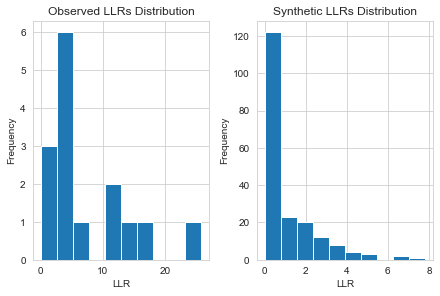

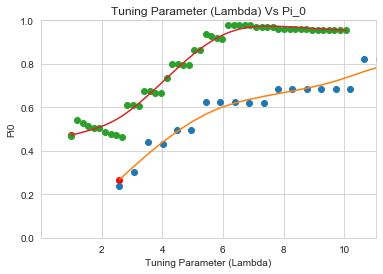

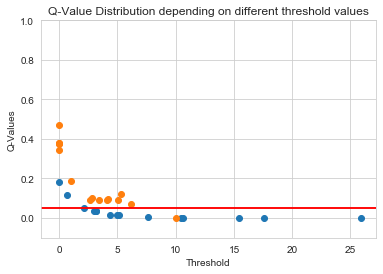

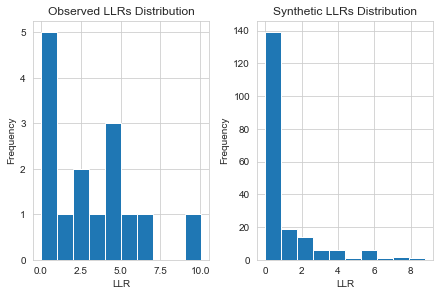

In [10]:
modelselection = model_selection.ModelSelection()
modelselection_obs = modelselection.model_selection_for_list_new(observed_timepoints = time, observed_cells = detrended_data, number_of_synthetic_cells = 200, control_q_value = 0.05, initial_guess = [start_alpha, start_beta, start_variance, start_noise])
# - - - 
modelselection_control = modelselection.model_selection_for_list_new(observed_timepoints = time, observed_cells = detrended_control_data, number_of_synthetic_cells = 200, control_q_value = 0.05, initial_guess = [start_alpha, start_beta, start_variance, start_noise])

## 6. Extracting Results from Model Selection Process

From the model selection function you may access results such as:
 - **LLRs** (both from the observed group, control group and synthetic group)
 - **Estimated parameters** for the fitting of both the oscillatory and non-oscillatory model to the observed group.
 - **Q Values estimated** from the model selection process, which includes a 'passlist' which is 1 for a significant q_value (deemed oscillatory) and 0 if not.

In [15]:
# 1. LLRs 

LLRs_observed = modelselection_obs[0][0]
LLRs_control = modelselection_control[0][0]
LLRs_synthetic = np.vstack((modelselection_obs[0][1], modelselection_control[0][1]))

#print(" - - - - - - - - - - ")
#print("LLRs - Observed Cell")
#print(prep.Data_Export().export_LLRs_estimates(modelselection_obs[0]))
#print("LLRs - Control Cell")
#print(prep.Data_Export().export_LLRs_estimates(modelselection_control[0]))

# 2. Estimated Parameters 

parameters_observed = modelselection_obs[1]
parameters_control = modelselection_control[1]

print(" - - - - - - - - - - ")
print("Estimated Parameters - Observed Cell")
print(prep.Data_Export().export_parameter_estimates(parameters_observed))
print(" - - - - - - - - - - ")
print("Estimated Parameters - Control Cell")
print(prep.Data_Export().export_parameter_estimates(parameters_control))

# Period Analysis

print(" - - - - - - - - - - ")
print(prep.Data_Export().period_estimation(parameters_observed))

# 3. Q-Values -> True Positives, False Positives, True Negatives and False Negatives

q_values_observed = modelselection_obs[2]
q_values_control = modelselection_control[2]

contingency_table = modelselection.contingency_table(q_values_observed, q_values_control)

print(" - - - - - - - - - - ")
print("TP, FP, TN, FN")
print(prep.Data_Export().export_contingency_table(contingency_table))

 - - - - - - - - - - 
Estimated Parameters - Observed Cell
                   Cell1         Cell2         Cell3         Cell4  \
OUosc alpha     0.126189  3.826534e-01  5.411558e-01  8.123644e-01   
OUosc beta      0.392854  5.287418e-01  6.595395e-01  2.105904e-03   
OUosc variance  0.219858  4.703582e-01  5.339960e-01  6.409191e-01   
OUosc noise     0.328663  2.483594e-08  4.588417e-07  1.000000e-10   
OU alpha        0.441603  4.626436e-01  6.910986e-01  8.123728e-01   
OU variance     0.272818  4.645550e-01  5.156189e-01  6.409210e-01   
OU noise        0.251937  1.000000e-10  2.237819e-06  1.000000e-10   

                       Cell5         Cell6     Cell7         Cell8  \
OUosc alpha     5.089399e-01  1.569148e-01  0.244594  3.811276e-01   
OUosc beta      5.289409e-01  3.710353e-01  1.110680  5.198435e-01   
OUosc variance  2.430875e-01  1.028735e+00  0.217492  5.433405e-01   
OUosc noise     1.337771e-01  1.988843e-01  0.341003  1.000000e-10   
OU alpha        7.436515e-01  